Задание

Считать информацию из найденного объекта (из bar\qr кода, определение дорожного знака, номера на регистрационном знаке автомобиля).

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Дорожный знак

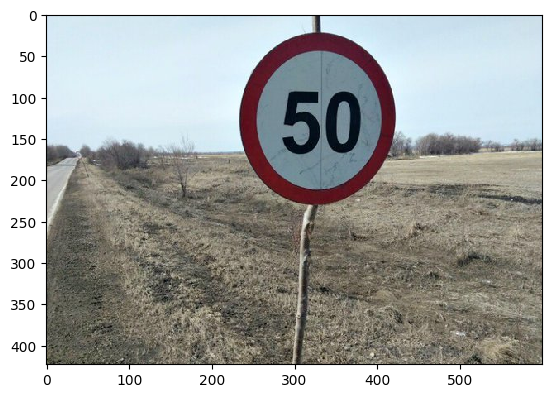

In [2]:
road_sign_row = cv.imread("road_sign.jpg")[:,:,::-1]

plt.imshow(road_sign_row, interpolation = 'none');

Картинка в тонах серого, значения по линии 50

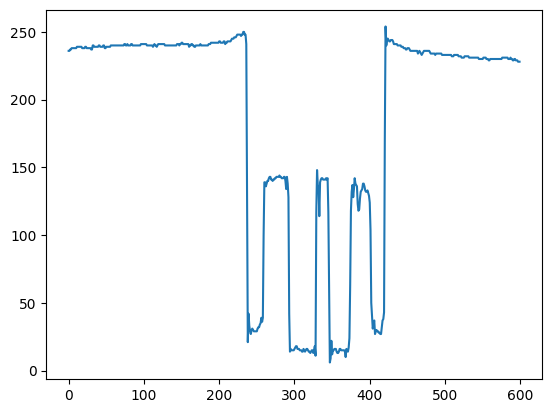

In [3]:
road_sign = cv.cvtColor(road_sign_row, cv.COLOR_BGR2GRAY)
plt.plot(road_sign[100])

Черный и красный выделяются. Сделаю бинарную картинку, отрезав значения

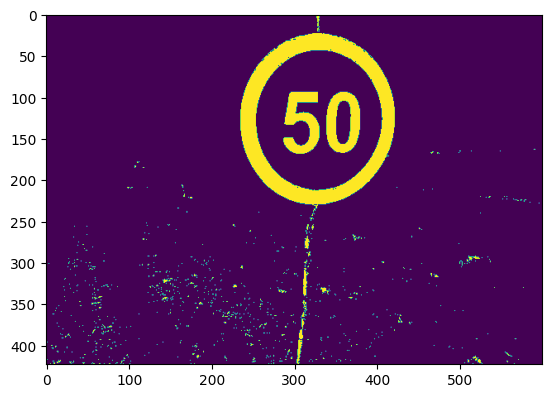

In [4]:
road_sign_gray_bin = []
for row in road_sign:
    new_row = []
    for elem in row:
        if elem < 50:
            new_row += [1]
        else:
            new_row += [0]  
    road_sign_gray_bin += [new_row]
road_sign_gray_bin = np.array(road_sign_gray_bin, dtype='uint8')
plt.imshow(road_sign_gray_bin)

Поиск компонент на картинке

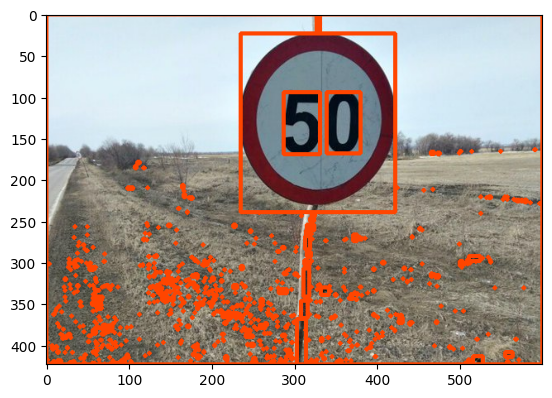

In [5]:
reval, labels, stats, centroids = cv.connectedComponentsWithStats(road_sign_gray_bin)
stats = sorted(stats, key= lambda stat: stat[cv.CC_STAT_AREA], reverse = True)
img_cont = road_sign_row.copy()
for obj in stats:
    left, top, wight, height, area = obj
    cv.rectangle(img_cont, (left,top), (left+wight,top+height), (255, 69, 0), 3);
plt.imshow(img_cont, cmap = 'gray')

Цифры отлично выделяются в отдельные компоненты

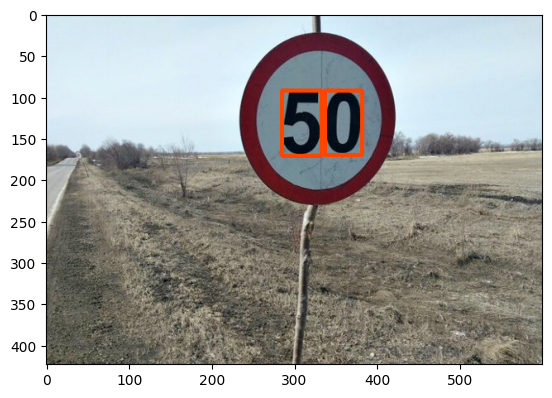

In [6]:
img_cont = road_sign_row.copy()
left, top, wight, height, area = stats[2]
cv.rectangle(img_cont, (left-2,top-2), (left+wight+2,top+height+2), (255, 69, 0), 3);

left, top, wight, height, area = stats[3]
cv.rectangle(img_cont, (left-2,top-2), (left+wight+2,top+height+2), (255, 69, 0), 3);
plt.imshow(img_cont, cmap = 'gray')

Создание меток с цифрами

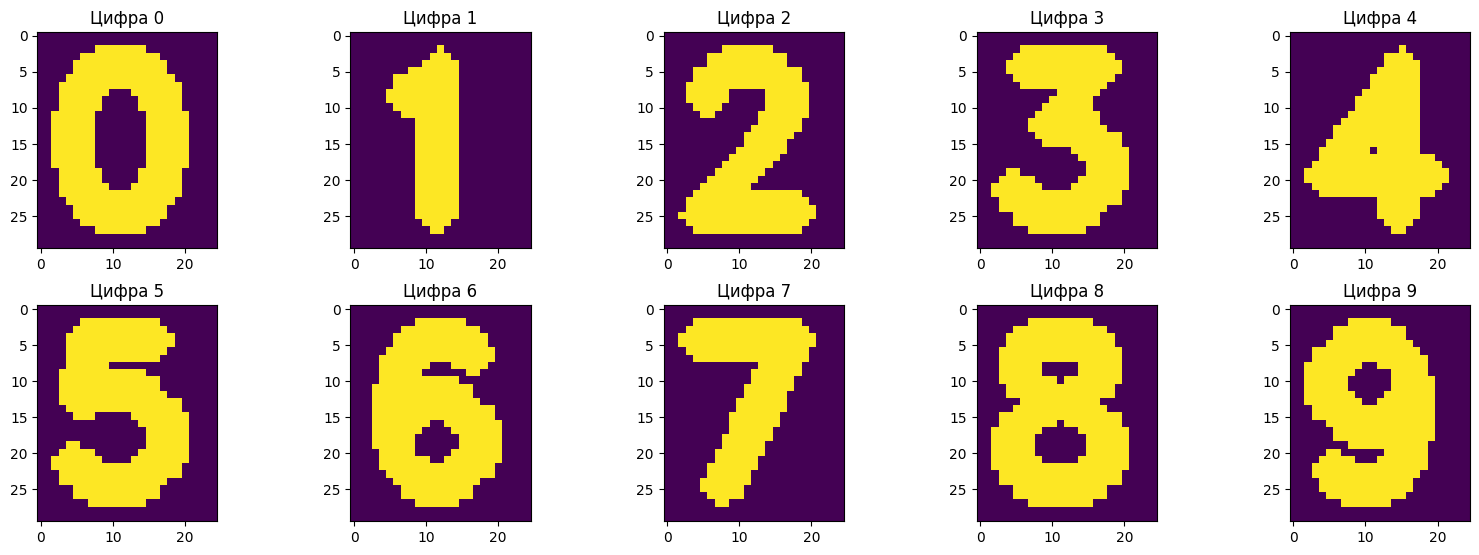

In [7]:
font = cv.QT_FONT_NORMAL
fontScale = 1
lineType = cv.LINE_4

plt.figure(figsize=(16, 6))
numbs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
imgs = []
for numb in numbs:
    count = numb + 1
    ax = plt.subplot(2,5,count)
    img = np.zeros((30, 25), "uint8")
    #img = cv.erode(cv.putText(img,f'{numb}', (1, 25), 
    #            font, fontScale, 200, lineType), None, iterations = 1);
    cv.putText(img,f'{numb}', (1, 25), 
                font, fontScale, 200, lineType)
    ax.imshow( img, interpolation = 'none' );
    ax.set_title(f'Цифра {numb}')
    imgs += [img]

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Вырезание цифр

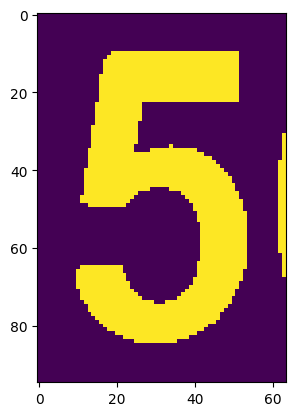

In [8]:
left, top, wight, height, area = stats[2]
x1, y1, x2, y2 = left-10,top-10, left+wight+10,top+height+10 #вырезание с небольшим отступом
img1 = road_sign_gray_bin[y1:y2,x1:x2]
plt.imshow(img1)

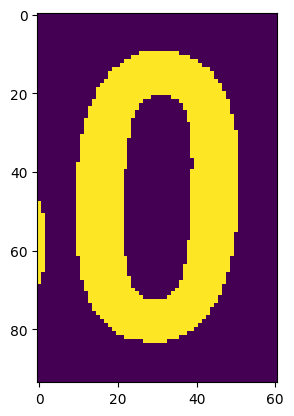

In [9]:
left, top, wight, height, area = stats[3]
x1, y1, x2, y2 = left-10,top-10, left+wight+10,top+height+10 #вырезание с небольшим отступом
img2 = road_sign_gray_bin[y1:y2,x1:x2]
plt.imshow(img2)

In [173]:
def multi_search(img_for_find, numbs, imgs):
    centers = []
    #поиск каждой цифры
    for numb, img in zip(numbs, imgs):
        
        #поиск по изображению разных масштабов
        im2gr_0 = img_for_find.copy() #копирование исходного изображения
        im2gr_1 = cv.pyrDown(im2gr_0)
        
        ff = 1.  # Исходный масштаб.
        f99 = 0.99  # Шаг масштаба.
        mm = []
        for i in range(80):
            ff = ff * f99
            im2gr__ = cv.resize( im2gr_1, None, fx = ff, fy=ff, interpolation = cv.INTER_CUBIC)
            if im2gr__.shape[0] >= img.shape[0] & im2gr__.shape[1] >= img.shape[1]: #условие что картинка больше шаблона
                cc = cv.matchTemplate(im2gr__, img, cv.TM_CCORR_NORMED)
                # Наилучшее значение при поиске по образцу это значение наиболее близкое к 1.
                mm.append(np.max( cc )) # В список сохраняются максимальные значения.
                
                
        #выбор масшатаба с бОльшей корреляцией 
        fff = f99**(mm.index(max(mm))+2) # Интегральное значение коеффицинта маштабирования.
        im2gr__ = cv.resize(im2gr_1, None, fx = fff, fy=fff, interpolation = cv.INTER_CUBIC)
        cc = cv.matchTemplate(im2gr__, img, cv.TM_CCORR_NORMED)

        # поиск центра метки
        mrkrs2 = (cc>0.78).astype("uint8")
        if mrkrs2.any():
            retv, lab, stats, cent = cv.connectedComponentsWithStats(im2gr__)
            cent = cent[1:] # Убираем центр фона
            
            if len(cent) == 1: #на картинке всего одно совпадение должно быть
                print('Цифра', numb, ', корреляция: ', round(np.max( cc ), 2))
                
                left, top, wight, height, area = stats[1]
                cv.rectangle(im2gr__, (left-1,top-1), (left+wight+1,top+height+1), (1), 1);
                plt.imshow(im2gr__)
                #plt.plot(cent[:,0]+7*fff, cent[:,1]+17*fff, "r*" );
                plt.show()

Цифра 0 , корреляция:  0.81


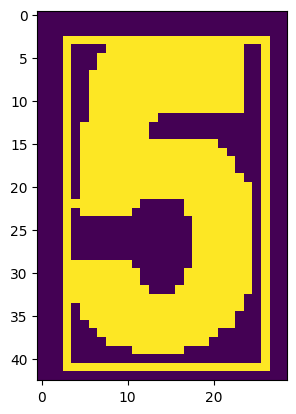

Цифра 5 , корреляция:  0.8


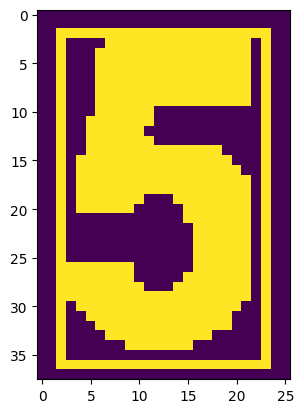

In [174]:
prep_img = img1.copy()
prep_img = cv.erode(prep_img, None, iterations=2)
prep_img = cv.dilate(prep_img, None, iterations=4)
multi_search(prep_img, numbs, imgs)

Цифра 0 , корреляция:  0.78


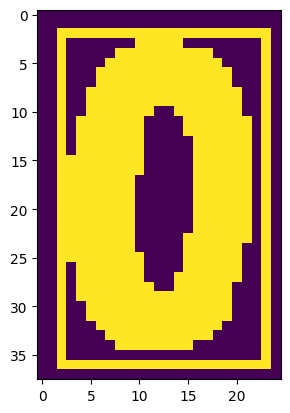

In [175]:
prep_img = img2.copy()
prep_img = cv.erode(prep_img, None, iterations=2)
prep_img = cv.dilate(prep_img, None, iterations=4)
multi_search(prep_img, numbs, imgs)